In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
import sys

from EMG_gestures.utils import *

In [2]:
results_folder = '../results_data/xsubject_transform_module/NN'

results_df = []
for model_id in range(0,6+1):
    # load model results
    results_fn = 'model_%02d_results.h5'%(model_id)
    model_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    model_df['Model'] = model_id
    #append to collective dataframe
    results_df.append(model_df)
results_df = pd.concat(results_df,axis = 0)

In [3]:
# Average over multiple train/test splits of the data
results_df = results_df.groupby(['Shuffled','Type','Model','Rep'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Subject'])

In [4]:
#drop accuracy score, working with f1 score
results_df = results_df.drop(columns=['accuracy_score'])

train_results_df = results_df.loc[results_df.Type == 'Train']
test_results_df = results_df.loc[results_df.Type == 'Val_Test']

train_summary = train_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns = ['Rep']).\
rename(columns={'f1_score':'Train_score'})

test_summary = test_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns = ['Rep']).\
rename(columns={'f1_score':'Test_score'})

summary_df = pd.concat([train_summary,test_summary],axis = 1)
summary_df

Epochs  Batch_Size  Train_Loss  Val_Loss  Epochs_Trained  \
Shuffled Model                                                             
False    0       200.0         2.0    0.200225  0.207683       29.202222   
         1       200.0         2.0    0.363126  0.236089       24.866667   
         2       200.0         2.0    0.345939  0.228544       25.517778   
         3       200.0         2.0    0.497956  0.272467       27.774444   
         4       200.0         2.0    0.578312  0.316217       30.660000   
         5       200.0         2.0    0.522592  0.290967       31.141111   
         6       200.0         2.0    0.762892  0.457013       37.757778   
True     0       200.0         2.0    1.386672  2.280411        7.506667   
         1       200.0         2.0    1.479394  2.257024        7.275556   
         2       200.0         2.0    1.472918  2.252083        7.096667   
         3       200.0         2.0    1.515172  2.230627        7.241111   
         4       200.0         2.0    1.553023  2.207694        7.522222   
         5       200.0         2.0    1.549491  2.207133        7.173333   
         6       200.0         2.0    1.633786  2.105845        7.208889   

                Train_score  Epochs  Batch_Size  Train_Loss  Val_Loss  \
Shuffled Model                                                          
False    0         0.958238   200.0         2.0    1.529704  1.307936   
         1         0.947129   200.0         2.0    0.517592  0.482931   
         2         0.949344   200.0         2.0    0.484306  0.467193   
         3         0.945952   200.0         2.0    0.676708  0.541113   
         4         0.919862   200.0         2.0    0.792079  0.646639   
         5         0.928623   200.0         2.0    0.763051  0.597446   
         6         0.865442   200.0         2.0    1.059079  0.899506   
True     0         0.343999   200.0         2.0    2.179749  2.131838   
         1         0.313237   200.0         2.0    1.542158  2.002872   
         2         0.317189   200.0         2.0    1.518105  1.986707   
         3         0.303942   200.0         2.0    1.584213  1.946385   
         4         0.271119   200.0         2.0    1.600002  1.993181   
         5         0.276194   200.0         2.0    1.577511  1.973324   
         6         0.233567   200.0         2.0    1.646928  1.898622   

                Epochs_Trained  Test_score  
Shuffled Model                              
False    0            6.000000    0.683736  
         1           20.791667    0.869371  
         2           21.463333    0.873668  
         3           24.256667    0.840997  
         4           22.558333    0.820918  
         5           21.241667    0.833932  
         6           23.978333    0.693769  
True     0            6.000000    0.146133  
         1           13.175000    0.120155  
         2           12.285000    0.118323  
         3           13.258333    0.114955  
         4           11.270000    0.115910  
         5           10.891667    0.112779  
         6           13.226667    0.097894

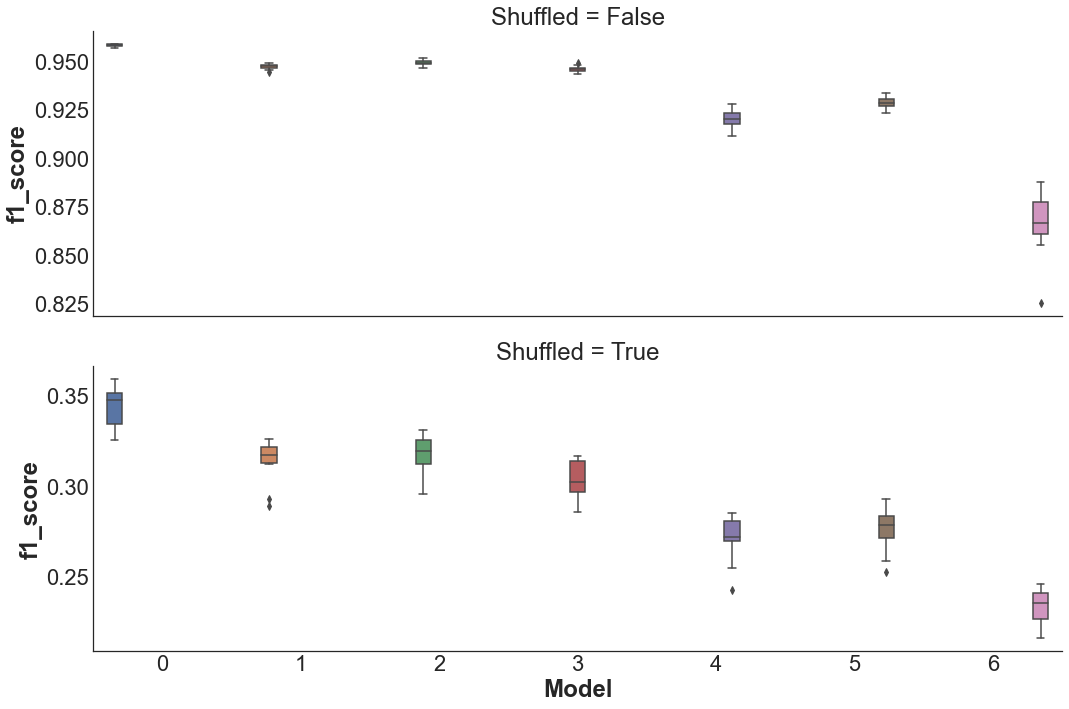

In [5]:
g = sns.catplot(data = train_results_df, x= 'Model', y = 'f1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

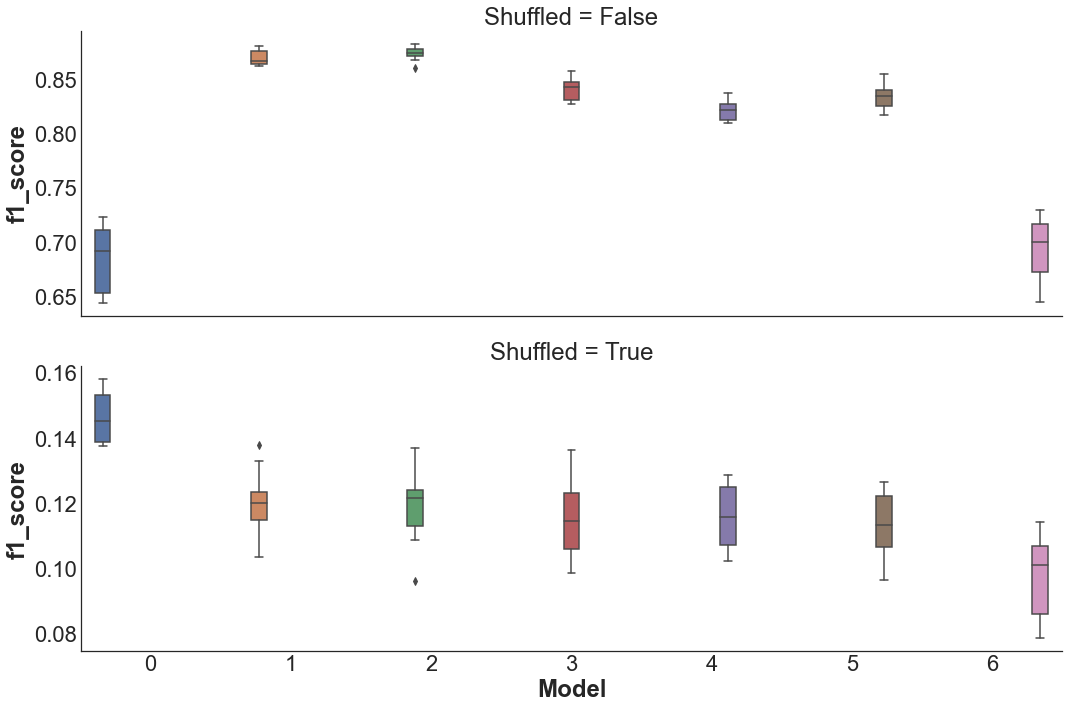

In [6]:
g = sns.catplot(data = test_results_df, x= 'Model', y = 'f1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

In [7]:
results_true_df = results_df.loc[results_df.Shuffled == False]

In [8]:
# Run ANOVA
model = ols('f1_score ~ C(Model)*C(Type)', results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.703286,6.0,490.987165,2.199246e-112
C(Type),0.598238,2.0,1252.949733,8.696966e-110
C(Model):C(Type),0.271805,12.0,94.877914,3.417402e-73
Residual,0.045120,189.0,NaN,NaN


In [9]:
groups =  results_true_df['Model'].map(str) + ' - ' + results_true_df['Type'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(results_true_df['f1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
    0 - Train  0 - Val_Test  -0.2745  0.001 -0.2995 -0.2495   True
    0 - Train 0 - Val_Train  -0.2745  0.001 -0.2995 -0.2495   True
    0 - Train     1 - Train  -0.0111    0.9 -0.0361  0.0139  False
    0 - Train  1 - Val_Test  -0.0889  0.001 -0.1139 -0.0638   True
    0 - Train 1 - Val_Train  -0.0444  0.001 -0.0694 -0.0194   True
    0 - Train     2 - Train  -0.0089    0.9 -0.0339  0.0161  False
    0 - Train  2 - Val_Test  -0.0846  0.001 -0.1096 -0.0595   True
    0 - Train 2 - Val_Train  -0.0383  0.001 -0.0634 -0.0133   True
    0 - Train     3 - Train  -0.0123    0.9 -0.0373  0.0127  False
    0 - Train  3 - Val_Test  -0.1172  0.001 -0.1423 -0.0922   True
    0 - Train 3 - Val_Train  -0.0567  0.001 -0.0817 -0.0317   True
    0 - Train     4 - Train  -0.0384  0.001 -0.0634 -0.0134   

In [10]:
test_results_true_df = results_df.loc[(results_df.Type == 'Val_Test')&(results_df.Shuffled == False)]
train_results_true_df = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]


In [11]:
# Run ANOVA
model = ols('f1_score ~ C(Model)', test_results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.382729,6.0,193.270587,1.321005e-38
Residual,0.020793,63.0,NaN,NaN


In [12]:
groups =  test_results_true_df['Model'].map(str) #+ ' - ' + test_results_true_df['Shuffled'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(test_results_true_df['f1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)

#p_values = psturng(np.abs(mc_results.meandiffs / mc_results.std_pairs), len(mc_results.groupsunique), mc_results.df_total)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.1856  0.001  0.1609  0.2104   True
     0      2   0.1899  0.001  0.1652  0.2147   True
     0      3   0.1573  0.001  0.1325   0.182   True
     0      4   0.1372  0.001  0.1124  0.1619   True
     0      5   0.1502  0.001  0.1255  0.1749   True
     0      6     0.01 0.8696 -0.0147  0.0348  False
     1      2   0.0043    0.9 -0.0204   0.029  False
     1      3  -0.0284 0.0146 -0.0531 -0.0036   True
     1      4  -0.0485  0.001 -0.0732 -0.0237   True
     1      5  -0.0354  0.001 -0.0602 -0.0107   True
     1      6  -0.1756  0.001 -0.2003 -0.1509   True
     2      3  -0.0327 0.0029 -0.0574 -0.0079   True
     2      4  -0.0527  0.001 -0.0775  -0.028   True
     2      5  -0.0397  0.001 -0.0645  -0.015   True
     2      6  -0.1799  0.001 -0.2046 -0.1552   True
     3      4  -0.0201 0.1874 -0.0448  0.0047 